# Building CLIP model to predict memes

In [6]:
# =============================
# IMPORTS & CONFIG
# =============================
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# CONFIG
# =============================
DATA_DIR = "data/raw"
TRAIN_CSV = f"{DATA_DIR}/Train/Train.csv"
TRAIN_IMG_DIR = f"{DATA_DIR}/Train/Image"
TEST_CSV = f"{DATA_DIR}/Test/Test.csv"
TEST_IMG_DIR = f"{DATA_DIR}/Test/Image"

BATCH_SIZE = 16  # Smaller batch size for CLIP
EPOCHS = 15
LR = 1e-5
PATIENCE = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


# Load Data

In [7]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

classes = sorted(train_df["Label"].unique())
label2id = {c:i for i,c in enumerate(classes)}
id2label = {v:k for k,v in label2id.items()}

# Split into train and validation
train_split, val_split = train_test_split(
    train_df, 
    test_size=0.15, 
    random_state=42, 
    stratify=train_df["Label"]
)

print(f"Train samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"Test samples: {len(test_df)}")
print(f"\nClass distribution:")
print(train_split["Label"].value_counts())

Train samples: 2431
Validation samples: 429
Test samples: 330

Class distribution:
Label
NonPolitical    1706
Political        725
Name: count, dtype: int64


# Load CLIP Model

In [8]:
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

print(f"Loaded CLIP model: {model_name}")
print(f"Vision embedding dim: {clip_model.config.vision_config.hidden_size}")
print(f"Projection dim: {clip_model.config.projection_dim}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded CLIP model: openai/clip-vit-base-patch32
Vision embedding dim: 768
Projection dim: 512


# Dataset Class

In [9]:
class CLIPMemeDataset(Dataset):
    def __init__(self, df, img_dir, processor, train=True, label2id=None):
        self.df = df
        self.img_dir = img_dir
        self.processor = processor
        self.train = train
        self.label2id = label2id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Image_name"])
        
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            # Fallback for corrupted images
            img = Image.new('RGB', (224, 224), (128, 128, 128))
        
        # Process image with CLIP processor
        inputs = self.processor(images=img, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)

        if self.train:
            label = self.label2id[row["Label"]]
            return pixel_values, label
        
        return pixel_values, row["Image_name"]

#  Create Dataloaders

In [10]:
train_ds = CLIPMemeDataset(train_split, TRAIN_IMG_DIR, processor, True, label2id)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_ds = CLIPMemeDataset(val_split, TRAIN_IMG_DIR, processor, True, label2id)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_ds = CLIPMemeDataset(test_df, TEST_IMG_DIR, processor, False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Dataloaders created!")

Dataloaders created!


# CLIP Classifier Model

In [11]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=2, dropout=0.3):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model
        
        # Freeze CLIP vision encoder initially (optional - can unfreeze later)
        for param in self.clip.vision_model.parameters():
            param.requires_grad = False
        
        # Classification head
        hidden_size = self.clip.config.projection_dim
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, pixel_values):
        # Get image embeddings from CLIP
        vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
        image_embeds = vision_outputs.pooler_output  # [batch_size, hidden_size]
        
        # Project to CLIP's projection space
        image_embeds = self.clip.visual_projection(image_embeds)
        
        # Classify
        logits = self.classifier(image_embeds)
        return logits
    
    def unfreeze_vision_model(self):
        """Unfreeze CLIP vision model for fine-tuning"""
        for param in self.clip.vision_model.parameters():
            param.requires_grad = True
        print("✓ CLIP vision model unfrozen for fine-tuning")

model = CLIPClassifier(clip_model, num_classes=len(classes)).to(device)
print(f"CLIP Classifier created with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

CLIP Classifier created with 63,953,155 trainable parameters


# Training Setup

In [12]:
# Calculate class weights
class_counts = Counter(train_split["Label"].map(label2id))
class_weights = torch.tensor(
    [1.0 / class_counts[i] for i in range(len(classes))],
    dtype=torch.float32
).to(device)
class_weights = class_weights / class_weights.sum() * len(classes)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))

print(f"Class weights: {class_weights}")
print(f"Optimizer: AdamW (lr={LR})")
print(f"Scheduler: ReduceLROnPlateau")

Class weights: tensor([0.5965, 1.4035])
Optimizer: AdamW (lr=1e-05)
Scheduler: ReduceLROnPlateau


/tmp/ipykernel_175568/2972907319.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))


# Training Loop

In [14]:
best_f1 = 0
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(EPOCHS):
    # Optional: Unfreeze CLIP after a few epochs
    if epoch == 5:
        model.unfreeze_vision_model()
        # Recreate optimizer with lower LR for fine-tuning
        optimizer = optim.AdamW(model.parameters(), lr=LR/10, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
    
    # Training phase
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for pixel_values, labels in pbar:
        pixel_values, labels = pixel_values.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(enabled=(device=='cuda')):
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    train_loss /= len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for pixel_values, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            pixel_values, labels = pixel_values.to(device), labels.to(device)
            
            with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                outputs = model(pixel_values)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    
    # Update scheduler
    scheduler.step(val_f1)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'models/clip_model.pth')
        print(f"  ✓ Best model saved! (Val F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break
    print("-" * 50)

print(f"\nTraining finished! Best Val F1: {best_f1:.4f}")

Epoch 1/15 [Train]:   0%|          | 0/152 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 1/15 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 1/15 [Val]: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]



Epoch 1/15:
  Train Loss: 0.3061, Train Acc: 0.8959
  Val Loss: 0.3495, Val Acc: 0.8928, Val F1: 0.8656
  ✓ Best model saved! (Val F1: 0.8656)
--------------------------------------------------


Epoch 2/15 [Train]:   0%|          | 0/152 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 2/15 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 2/15 [Val]: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]



Epoch 2/15:
  Train Loss: 0.1699, Train Acc: 0.9535
  Val Loss: 0.3530, Val Acc: 0.8881, Val F1: 0.8619
  No improvement (1/5)
--------------------------------------------------


Epoch 3/15 [Train]:   0%|          | 0/152 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 3/15 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 3/15 [Val]: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]



Epoch 3/15:
  Train Loss: 0.0867, Train Acc: 0.9811
  Val Loss: 0.3976, Val Acc: 0.9021, Val F1: 0.8779
  ✓ Best model saved! (Val F1: 0.8779)
--------------------------------------------------


Epoch 4/15 [Train]:   0%|          | 0/152 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 4/15 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 4/15 [Val]: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]



Epoch 4/15:
  Train Loss: 0.0361, Train Acc: 0.9947
  Val Loss: 0.6086, Val Acc: 0.9044, Val F1: 0.8779
  No improvement (1/5)
--------------------------------------------------


Epoch 5/15 [Train]:   0%|          | 0/152 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 5/15 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 5/15 [Val]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]



Epoch 5/15:
  Train Loss: 0.0166, Train Acc: 0.9967
  Val Loss: 0.7929, Val Acc: 0.9021, Val F1: 0.8746
  No improvement (2/5)
--------------------------------------------------
✓ CLIP vision model unfrozen for fine-tuning


Epoch 6/15 [Train]:   0%|          | 0/152 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 6/15 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 6/15 [Val]: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]



Epoch 6/15:
  Train Loss: 0.0089, Train Acc: 0.9984
  Val Loss: 0.8827, Val Acc: 0.8998, Val F1: 0.8766
  No improvement (3/5)
--------------------------------------------------


Epoch 7/15 [Train]:   0%|          | 0/152 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 7/15 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 7/15 [Val]: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]



Epoch 7/15:
  Train Loss: 0.0001, Train Acc: 1.0000
  Val Loss: 1.0042, Val Acc: 0.8951, Val F1: 0.8695
  No improvement (4/5)
--------------------------------------------------


Epoch 8/15 [Train]:   0%|          | 0/152 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 8/15 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_175568/1999252382.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 8/15 [Val]: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 8/15:
  Train Loss: 0.0001, Train Acc: 1.0000
  Val Loss: 1.0708, Val Acc: 0.8951, Val F1: 0.8695
  No improvement (5/5)

Early stopping triggered after 8 epochs

Training finished! Best Val F1: 0.8779


# Validation Results

Final validation: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]



FINAL VALIDATION RESULTS

Classification Report:
              precision    recall  f1-score   support

NonPolitical       0.91      0.96      0.93       301
   Political       0.89      0.77      0.82       128

    accuracy                           0.90       429
   macro avg       0.90      0.86      0.88       429
weighted avg       0.90      0.90      0.90       429



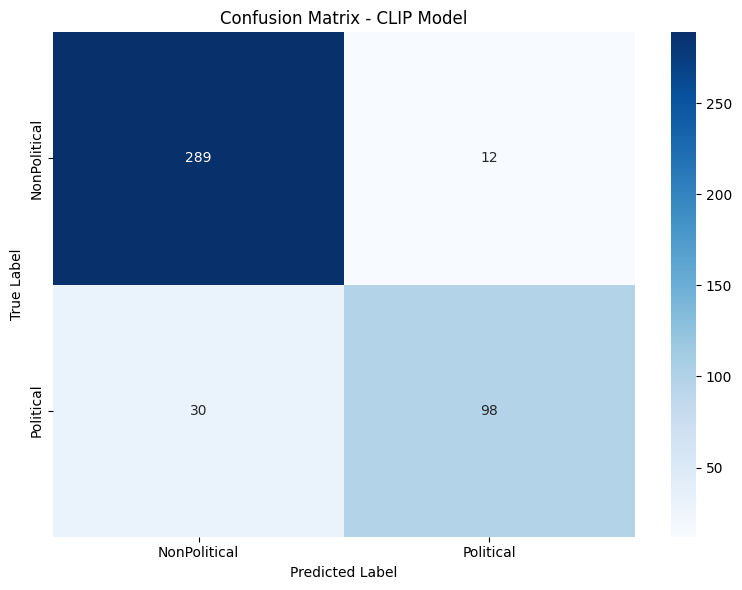


✓ Confusion matrix saved as 'confusion_matrix_clip.png'


In [ ]:
# Load best model
model.load_state_dict(torch.load('models/clip_model.pth'))
model.eval()

# Get final validation predictions
val_preds, val_labels = [], []
with torch.no_grad():
    for pixel_values, labels in tqdm(val_loader, desc="Final validation"):
        pixel_values = pixel_values.to(device)
        outputs = model(pixel_values)
        preds = torch.argmax(outputs, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Print classification report
print("\n" + "="*50)
print("FINAL VALIDATION RESULTS")
print("="*50)
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=[id2label[i] for i in range(len(classes))]))

# Plot confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2label[i] for i in range(len(classes))],
            yticklabels=[id2label[i] for i in range(len(classes))])
plt.title('Confusion Matrix - CLIP Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('assets/confusion_matrix_clip.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved as 'assets/confusion_matrix_clip.png'")

In [18]:
# # Plot training history
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # Loss plot
# axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
# axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Loss')
# axes[0].set_title('Training and Validation Loss')
# axes[0].legend()
# axes[0].grid(True)

# # Accuracy plot
# axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
# axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Accuracy')
# axes[1].set_title('Training and Validation Accuracy')
# axes[1].legend()
# axes[1].grid(True)

# # F1 Score plot
# axes[2].plot(history['val_f1'], label='Val F1 Score', marker='d', color='green')
# axes[2].set_xlabel('Epoch')
# axes[2].set_ylabel('F1 Score')
# axes[2].set_title('Validation F1 Score')
# axes[2].legend()
# axes[2].grid(True)

# plt.tight_layout()
# plt.savefig('training_history_clip.png', dpi=150, bbox_inches='tight')
# plt.show()

# print("✓ Training history saved as 'training_history_clip.png'")

# Test Predictions & Submission

In [19]:
model.eval()
preds = []
image_names = []

with torch.no_grad():
    for pixel_values, names in tqdm(test_loader, desc="Predicting"):
        pixel_values = pixel_values.to(device)
        outputs = model(pixel_values)
        predicted = torch.argmax(outputs, dim=1).cpu().numpy()

        preds.extend([id2label[p] for p in predicted])
        image_names.extend(names)

# Create submission DataFrame
submission_df = pd.DataFrame({
    "Image_name": image_names,
    "Label": preds
})

# Save to CSV
submission_csv = "submissions/submission_clip.csv"
submission_df.to_csv(submission_csv, index=False)

print(f"Submission CSV saved at: {submission_csv}")
print(submission_df.head())
print(f"\nPrediction distribution:")
print(submission_df['Label'].value_counts())

Predicting: 100%|██████████| 21/21 [00:19<00:00,  1.09it/s]

Submission CSV saved at: submissions/submission_clip.csv
     Image_name         Label
0  test0001.jpg  NonPolitical
1  test0002.jpg  NonPolitical
2  test0003.jpg  NonPolitical
3  test0004.jpg  NonPolitical
4  test0005.jpg     Political

Prediction distribution:
Label
NonPolitical    234
Political        96
Name: count, dtype: int64
